<a href="https://colab.research.google.com/github/faizuddin1995/Faizuddin_dissertation_code_2023/blob/main/NEWxlnetwithoutfinetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#File authorization from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.8 MB/s eta 0:00:00


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Metrics:
Accuracy: 0.2125
Precision: 0.2930
Recall: 0.2125
F1-Score: 0.0838

Testing Metrics:
Accuracy: 0.2137
Precision: 0.2756
Recall: 0.2137
F1-Score: 0.0829


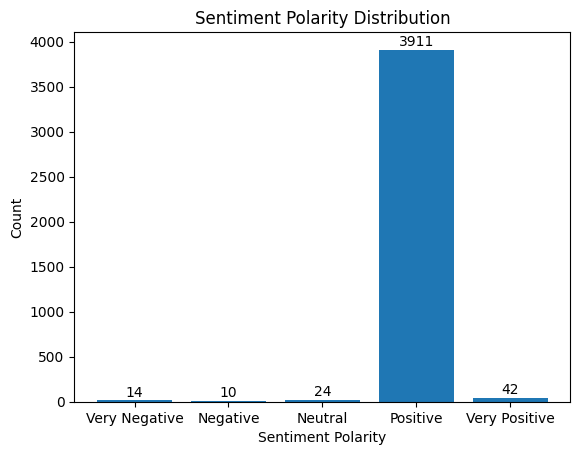

In [ ]:
!pip install transformers
!pip install sentencepiece

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the cleaned data
path = '/content/drive/MyDrive/data/new/cleaned_tweet_data.csv'
df = pd.read_csv(path, encoding='ISO-8859-1', on_bad_lines='skip')

# Split data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.4, random_state=42)

# Load the XLNet tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=5)

# Tokenize and encode the text data
def tokenize_data(text_list, tokenizer, max_length):
    inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt', max_length=max_length)
    return inputs

max_length = 64  # Maximum sequence length for XLNet
train_inputs = tokenize_data(train_data['content'].tolist(), tokenizer, max_length)
test_inputs = tokenize_data(test_data['content'].tolist(), tokenizer, max_length)

# Convert data to tensors
train_input_ids = train_inputs['input_ids']
train_attention_mask = train_inputs['attention_mask']
train_sentiment_labels = torch.tensor(train_data['sentiment_numeric'].values)  # Convert Series to NumPy array
test_input_ids = test_inputs['input_ids']
test_attention_mask = test_inputs['attention_mask']
test_sentiment_labels = torch.tensor(test_data['sentiment_numeric'].values)  # Convert Series to NumPy array

# Create TensorDatasets
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_sentiment_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_sentiment_labels)

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the model onto the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Make predictions
def predict_batch(model, input_ids, attention_mask):
    with torch.no_grad():
        model.eval()
        logits = model(input_ids.to(device), attention_mask=attention_mask.to(device)).logits
        return logits.argmax(dim=1).cpu().numpy()

train_preds = []
train_true_labels = []
for batch in train_dataloader:
    input_ids, attention_mask, true_labels = batch
    preds = predict_batch(model, input_ids, attention_mask)
    train_preds.extend(preds)
    train_true_labels.extend(true_labels.numpy())

test_preds = []
test_true_labels = []
for batch in test_dataloader:
    input_ids, attention_mask, true_labels = batch
    preds = predict_batch(model, input_ids, attention_mask)
    test_preds.extend(preds)
    test_true_labels.extend(true_labels.numpy())

# Calculate evaluation metrics
def evaluate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return accuracy, precision, recall, f1

train_accuracy, train_precision, train_recall, train_f1 = evaluate_metrics(train_true_labels, train_preds)
test_accuracy, test_precision, test_recall, test_f1 = evaluate_metrics(test_true_labels, test_preds)

# Print evaluation metrics
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")
print()
print("Testing Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Create a bar graph for polarity distribution with quantity labels
polarity_distribution = test_preds
polarity_counts = [polarity_distribution.count(i) for i in range(5)]
polarity_labels = ['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive']

plt.bar(polarity_labels, polarity_counts)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Count")

# Add quantity labels on top of the bars
for i, count in enumerate(polarity_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()